#Introducción

## Contexto empresarial y Objetivo

Una compañía de seguros de autos cuenta con una base de datos de los distintos individuos a los que les realizó una cotización de seguro. Este DataSet contiene características del individuo, características del contacto, variables asociadas al monto de la cotización y si finalmente el individuo contrató o no el servicio de seguros de autos. Con el fin de concentrar sus esfuerzos sobre los clientes más probables a comprar y no esforzarse en los menos probables, el objetivo de este análisis será predecir la variable Conversion_Status por medio de Aprendizaje Supervisado por Clasificación.

## Variables

Variable objetivo:
  Conversion_Status (texto): binario que indica con "1" si el cliente compró o no.
  
Las variables del DataSet son:
  

1.   Age (numérico): Edad del sujeto.
2.   Is_Senior (texto): Binario que indicado si la persona es o no mayor a 55 años.
3.   Marital_Status (texto): Estado Civil.
4.   Married_Premium_Discount (número): Descuento en caso de casado.
5.   Prior_Insurance (texto): Duración del seguro anterior al actual.
6.   Prior_Insurance_Premium_Adjustment (número): Descuento por duración del seguro anterior. 50 en caso de 1-5 años y 100 en caso de <1 año.
7.   Claims_Frequency (número): frecuencia anual de reclamos.
8.   Claims_Severity (texto): severidad de los reclamos.
9.   Claims_Adjustment (número): ajuste por reclamos (Frecuencia por severidad, considerando la severidad Low = 50, Medium = 100 y High = 200).
10.  Policy_Type (texto): tipo de cobertura (Full Coverage o Liability-Only).
11.  Policy_Adjustment (número): ajuste por Policy_Type (si es Liability-Only = -200, Full Coverage = 0).
12.  Premium_Amount (número): Promoción final.  
13.  Safe_Driver_Discount (texto): binario que indica con "1" si corresponde descuento por buen conductor.
14.  Multi_Policy_Discount (texto): binario que indica con "1" si corresponde descuento por múltiples.
15.  Bundling_Discount (texto): binario que indica con "1" si corresponde descuento por paquetes.
16.  Total_Discounts (número): Indica el descuento total que corrresponde a las últimas 3 variables. Suma los últimos 3 y los multiplica por 50.
17.  Source_of_Lead (texto): medio de contacto con el cliente. Puede ser Online, Agent o Referral.
18.  Time_Since_First_Contact (número): tiempo en días desde el primer contacto.
19.  Inquiries (número): cantidad de consultas.
20.  Quotes_Requested (número): cantidad de cotizaciones solicitadas.
21.  Time_to_Conversion (número): tiempo estimado para la conversión.
22.  Credit_Score (número): puntaje por historial crediticio.
23.  Premium_Adjustment_Credit (número): ajuste que depende del historial crediticio. Si el primer dígito de Credit_Score es =>7, entonces -50, sino 50.
24.  Region (texto): tipo de región del conductor. Puede ser Rural, Suburban o Urban.
25.  Premium_Adjustment_Region (número): ajuste por región siendo Rural = 0, Suburban = 50 y Urban = 100.

## Hipótesis

1. Los descuentos afectan el índice de conversión.
2. Las características del cliente están relacionadas al índice de conversión.
3. Los productos (Policy_Type) cuentan con distintos índices de conversión.
4. El historial crediticio del cliente impacta sobre el índice de conversión.

#Librerías

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

#Integración de datos

In [17]:
# Descargo el documento csv "synthetic_insurance_data.csv" del github "https://github.com/Mauro365/Coderhouse---Data-Science-II"

df = pd.read_csv("https://raw.githubusercontent.com/Mauro365/Coderhouse---Data-Science-II/main/synthetic_insurance_data.csv")
print(df.head())

   Age  Is_Senior Marital_Status  Married_Premium_Discount Prior_Insurance  \
0   47          0        Married                        86       1-5 years   
1   37          0        Married                        86       1-5 years   
2   49          0        Married                        86       1-5 years   
3   62          1        Married                        86        >5 years   
4   36          0         Single                         0        >5 years   

   Prior_Insurance_Premium_Adjustment  Claims_Frequency Claims_Severity  \
0                                  50                 0             Low   
1                                  50                 0             Low   
2                                  50                 1             Low   
3                                   0                 1             Low   
4                                   0                 2             Low   

   Claims_Adjustment    Policy_Type  ...  Time_Since_First_Contact  \
0         

#Data Wrangling

Por conocimiento del DataSet y compararlo con el objetivo, se define eliminar del análisis las columnas asociadas al cálculo de la cotización (se conservan las características y monto final ya que podrían apoyar al análisis)

In [18]:
df.drop(['Married_Premium_Discount', 'Prior_Insurance_Premium_Adjustment', 'Claims_Adjustment','Policy_Adjustment','Premium_Adjustment_Credit','Premium_Adjustment_Region'], axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       10000 non-null  int64  
 1   Is_Senior                 10000 non-null  int64  
 2   Marital_Status            10000 non-null  object 
 3   Prior_Insurance           10000 non-null  object 
 4   Claims_Frequency          10000 non-null  int64  
 5   Claims_Severity           10000 non-null  object 
 6   Policy_Type               10000 non-null  object 
 7   Premium_Amount            10000 non-null  int64  
 8   Safe_Driver_Discount      10000 non-null  int64  
 9   Multi_Policy_Discount     10000 non-null  int64  
 10  Bundling_Discount         10000 non-null  int64  
 11  Source_of_Lead            10000 non-null  object 
 12  Time_Since_First_Contact  10000 non-null  int64  
 13  Conversion_Status         10000 non-null  int64  
 14  Website

In [5]:
df.describe()

,Age,Is_Senior,Claims_Frequency,Premium_Amount,Safe_Driver_Discount,Multi_Policy_Discount,Bundling_Discount,Time_Since_First_Contact,Conversion_Status,Website_Visits,Inquiries,Quotes_Requested,Time_to_Conversion,Credit_Score
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,39.991700,0.159300,0.497200,2218.631400,0.199900,0.305100,0.097200,15.478000,0.576700,5.022900,1.996900,1.996900,7.443100,714.753529
std,14.050358,0.365974,0.716131,148.390408,0.399945,0.460473,0.296245,8.677975,0.494107,2.238231,1.415588,0.817409,4.021241,49.737995
min,18.000000,0.000000,0.000000,1800.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,530.184649
25%,29.000000,0.000000,0.000000,2100.000000,0.000000,0.000000,0.000000,8.000000,0.000000,3.000000,1.000000,1.000000,4.000000,681.632915
50%,39.000000,0.000000,0.000000,2236.000000,0.000000,0.000000,0.000000,16.000000,1.000000,5.000000,2.000000,2.000000,7.000000,715.109051
75%,50.000000,0.000000,1.000000,2336.000000,0.000000,1.000000,0.000000,23.000000,1.000000,6.000000,3.000000,3.000000,11.000000,748.191571
max,90.000000,1.000000,5.000000,2936.000000,1.000000,1.000000,1.000000,30.000000,1.000000,16.000000,9.000000,3.000000,14.000000,850.000000


In [6]:
df.isnull().sum()

,0
Age,0
Is_Senior,0
Marital_Status,0
Prior_Insurance,0
Claims_Frequency,0
Claims_Severity,0
Policy_Type,0
Premium_Amount,0
Safe_Driver_Discount,0
Multi_Policy_Discount,0


In [7]:
df.duplicated().sum()

0

In [ ]:
# Verifico los valores únicos por columna
for column in df.columns:
    únicos = df[column].unique()
    print(f"Valores únicos en columna '{column}': {únicos}")

Valores únicos en columna 'Age': [47 37 49 62 36 63 51 32 48 33 43 18 31 24 44 26 61 41 22 45 30 35 67 39
 52 21 20 42 38 29 55 34 53 27 54 23 60 40 46 68 76 57 72 25 28 59 80 50
 56 19 90 74 66 71 64 58 70 69 86 65 78 79 77 73 87 81 75 84 83 88 82]
Valores únicos en columna 'Is_Senior': [0 1]
Valores únicos en columna 'Marital_Status': ['Married' 'Single' 'Widowed' 'Divorced']
Valores únicos en columna 'Married_Premium_Discount': [86  0]
Valores únicos en columna 'Prior_Insurance': ['1-5 years' '>5 years' '<1 year']
Valores únicos en columna 'Prior_Insurance_Premium_Adjustment': [ 50   0 100]
Valores únicos en columna 'Claims_Frequency': [0 1 2 3 4 5]
Valores únicos en columna 'Claims_Severity': ['Low' 'Medium' 'High']
Valores únicos en columna 'Claims_Adjustment': [  0  50 100 200 150 400 300 600 250 800]
Valores únicos en columna 'Policy_Type': ['Full Coverage' 'Liability-Only']
Valores únicos en columna 'Policy_Adjustment': [   0 -200]
Valores únicos en columna 'Premium_Amount': [2

La data tiene un volumen de 10.000 registros. No contiene nulos o duplicados y no requiere estandarizar los valores únicos.
Por otro lado, ya se eliminaron las columnas que, desde la introducción, se sabía que su información no será útil al EDA.

#Exploratory Data Analysis

In [19]:
df_num = df.select_dtypes(include=[np.number])
df_cat = df.select_dtypes(include=[object])

##Análisis Univariado

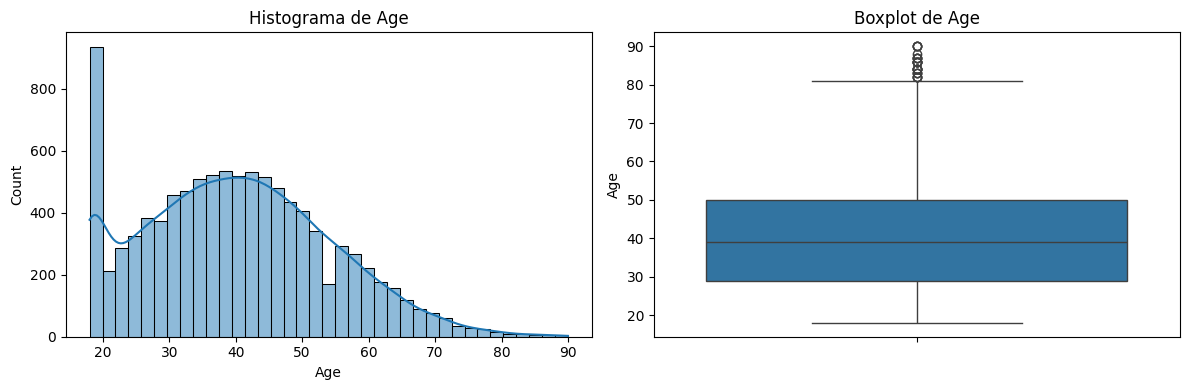

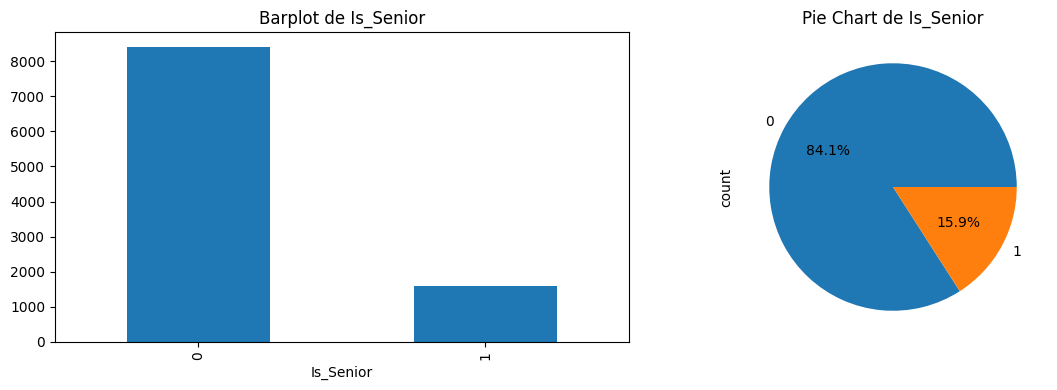

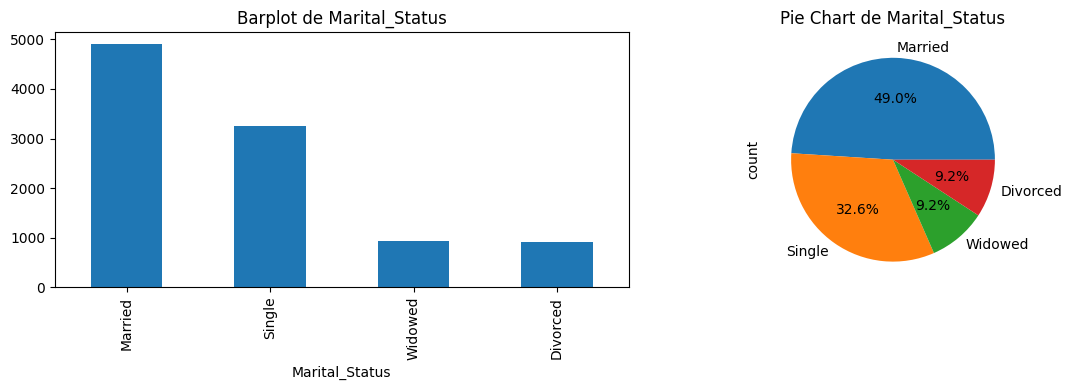

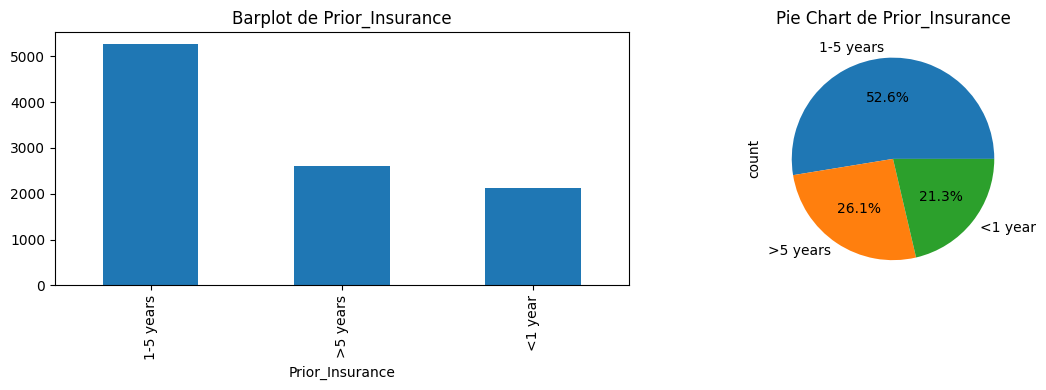

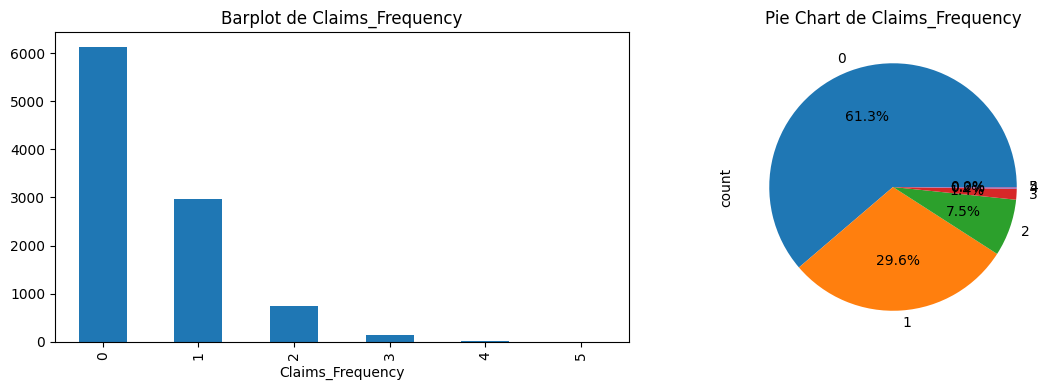

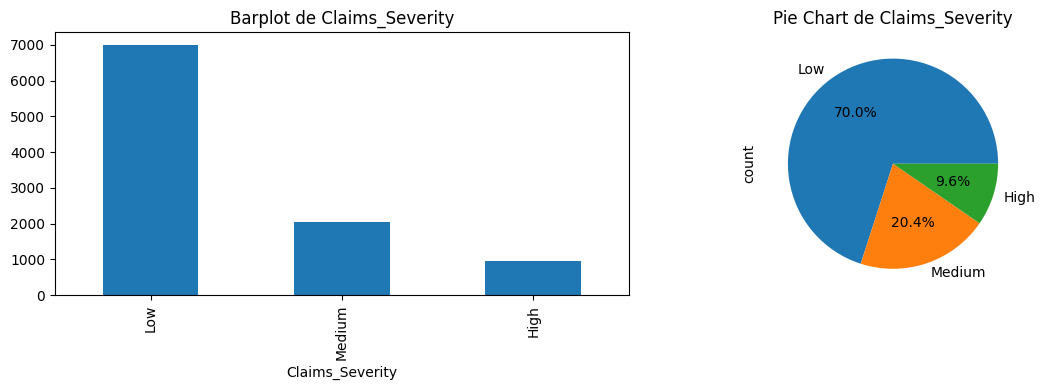

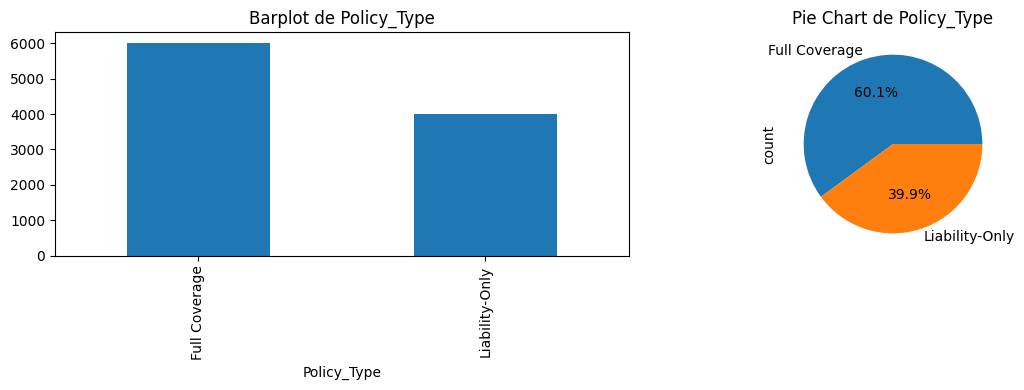

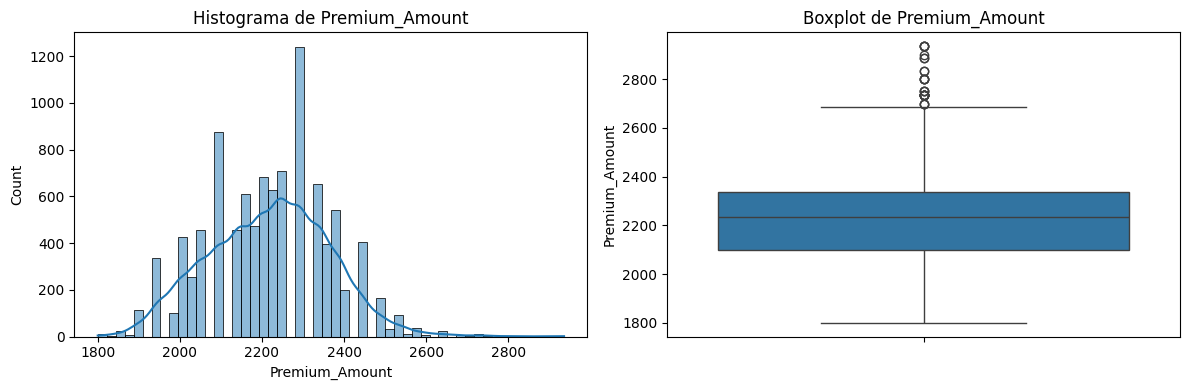

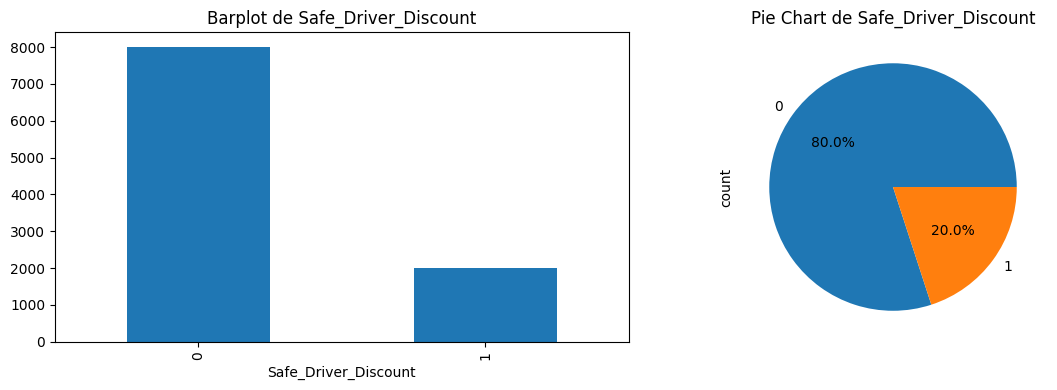

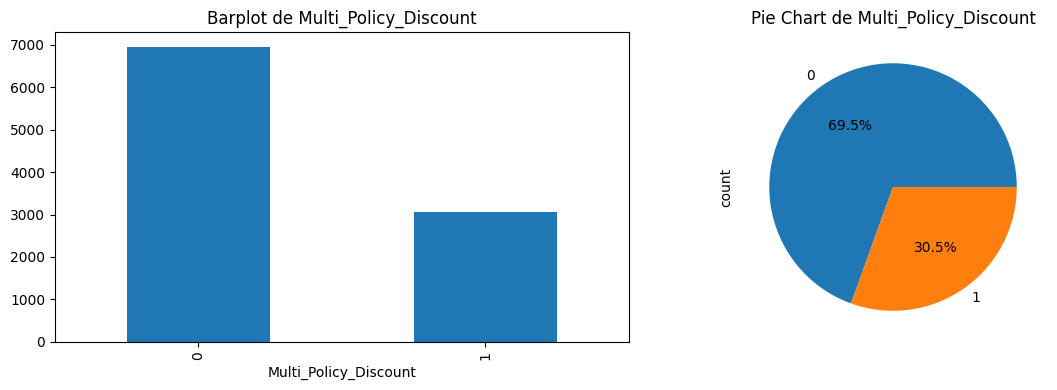

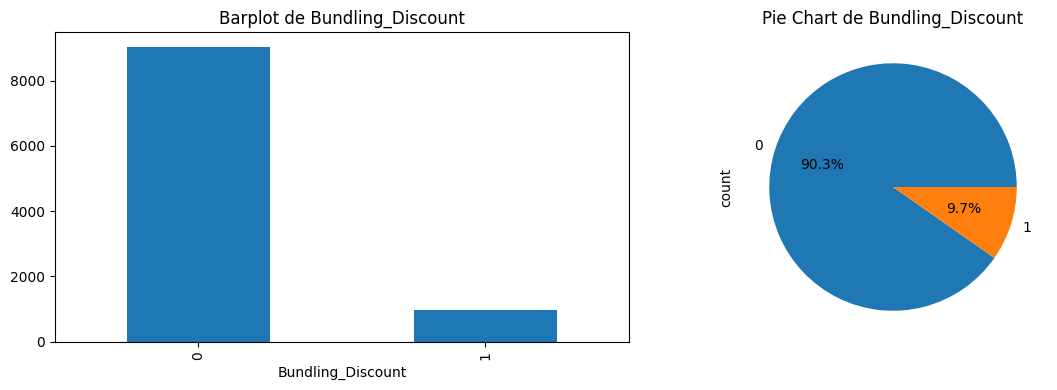

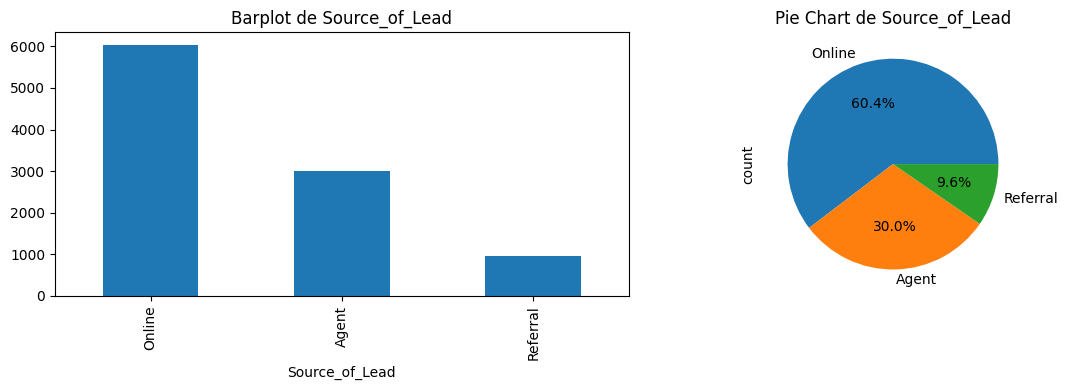

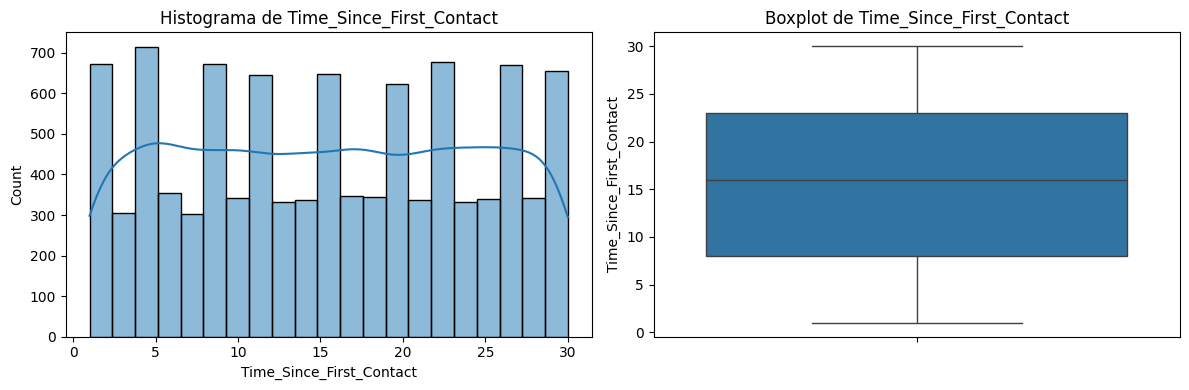

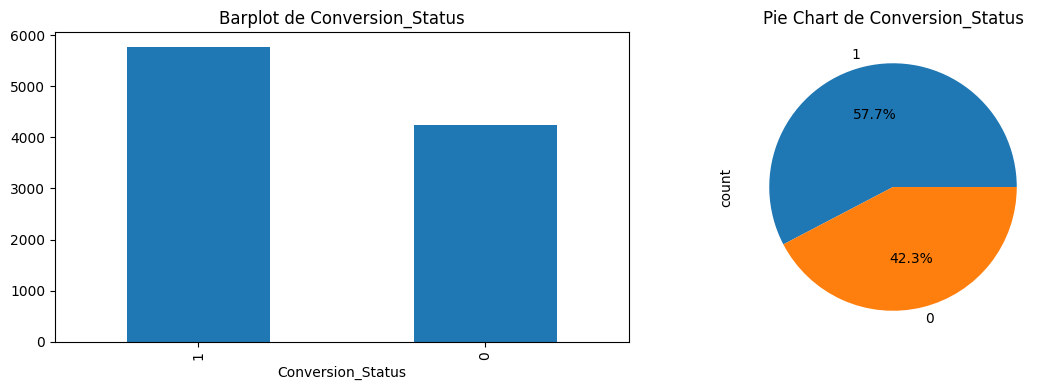

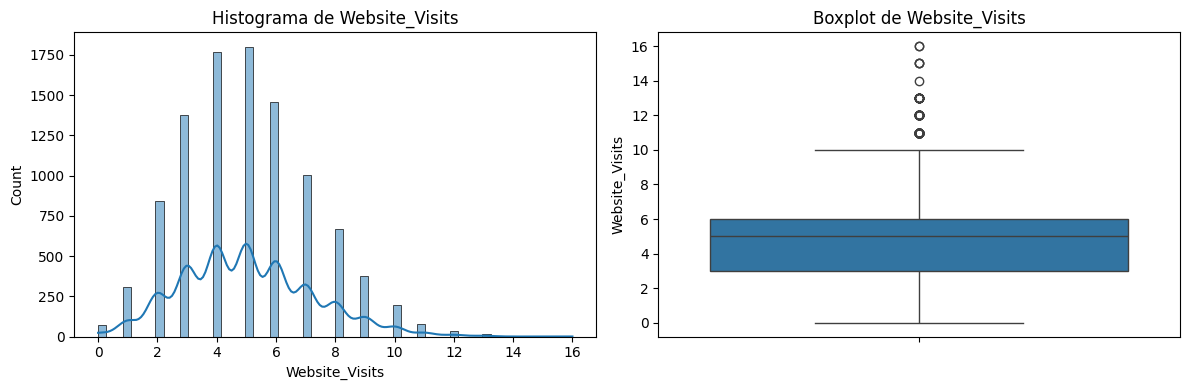

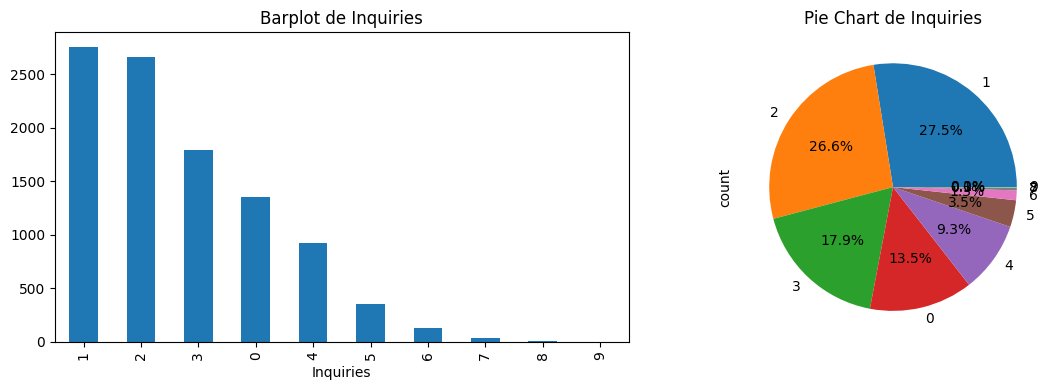

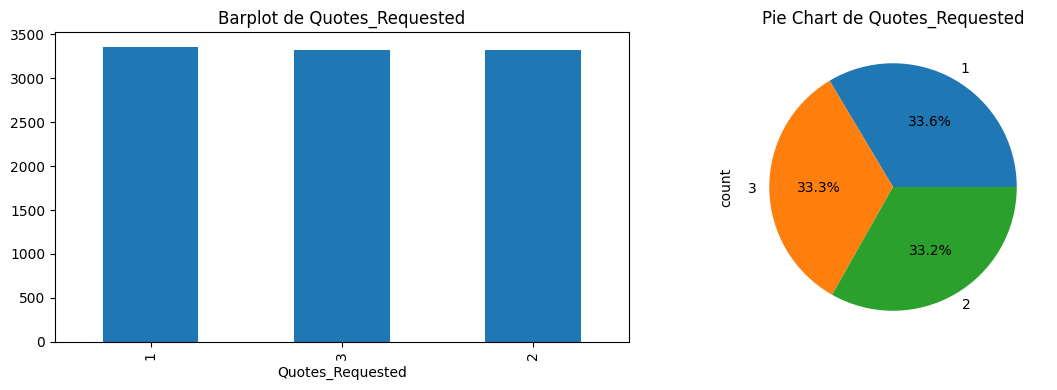

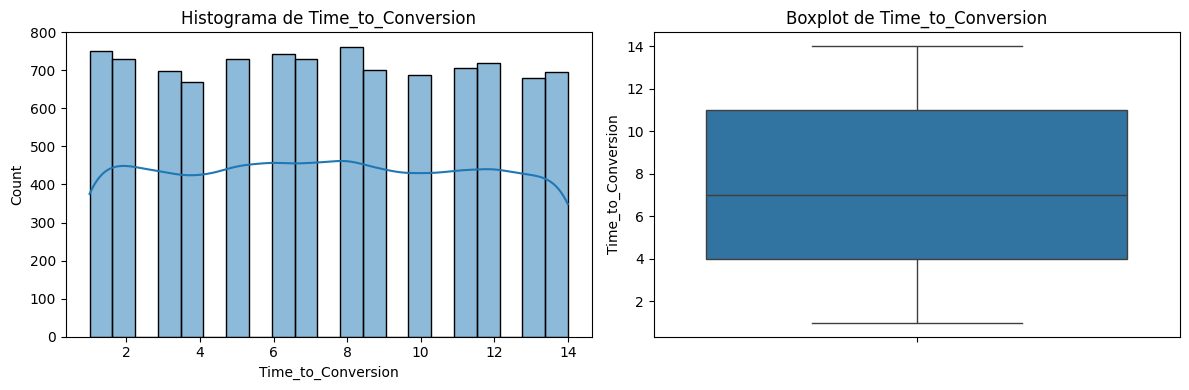

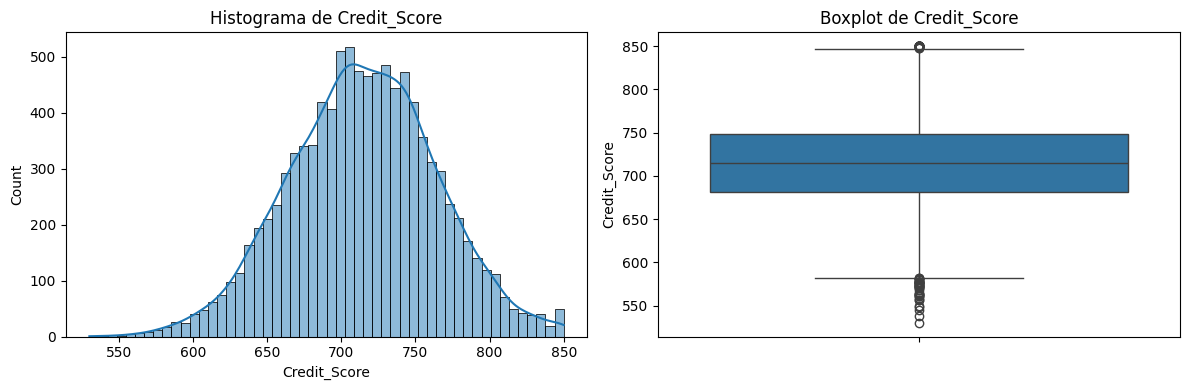

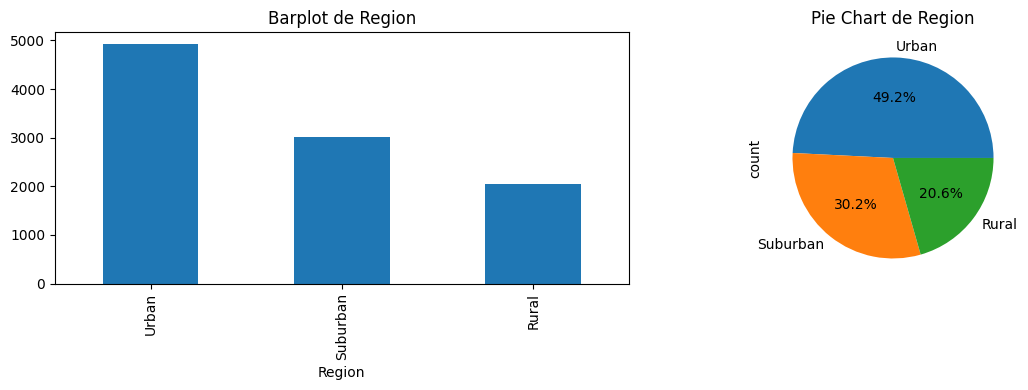

In [9]:
# Para cada variable, verifico un histograma y boxplot en casos de variable numérica con más de 10 valores únicos. Si son pocos casos numéricos o son categóricos, entonces se evalúa baprlot y piechart.

for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > 10:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True)
        plt.title(f'Histograma de {col}')
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot de {col}')
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        df[col].value_counts().plot(kind='bar')
        plt.title(f'Barplot de {col}')
        plt.subplot(1, 2, 2)
        df[col].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title(f'Pie Chart de {col}')
        plt.tight_layout()
        plt.show()


Se distingue que la variable objetivo Conversion_Status tiene 57,7% de casos positivos de conversión. Nos encontramos en un caso de clase balanceada.

##Análisis Bivariado

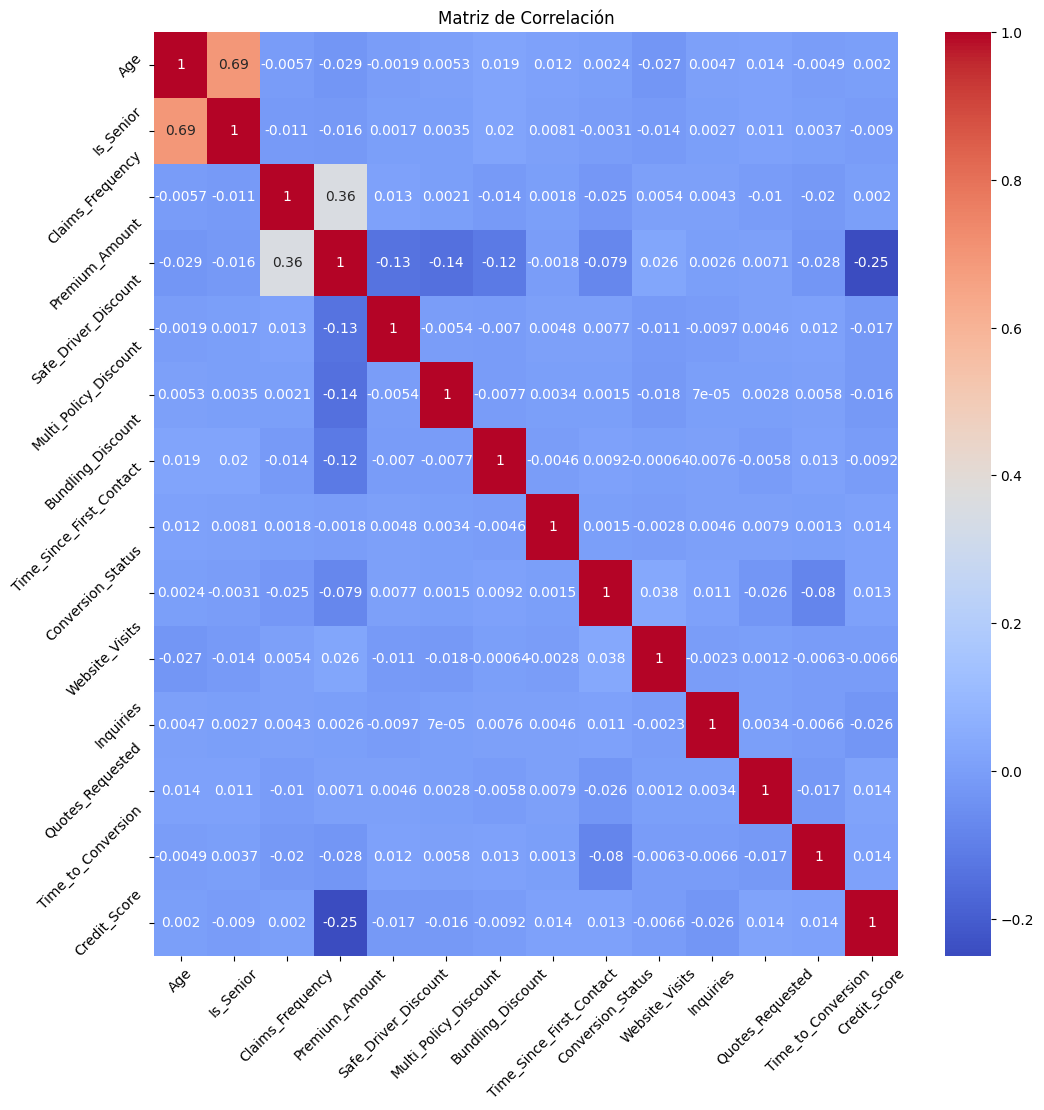

In [10]:
# Matriz de correlación
correlation_matrix = df_num.corr()

# Mapa de calor
plt.figure(figsize=(12,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

En principio, se analiza que no hay variables que tengan muy buena correlación con la variable objetivo Conversion_Status.

Conversion_Status          0          1
Is_Senior                              
0                  42.262400  57.737600
1                  42.686755  57.313245
Conversion_Status          0           1
Claims_Frequency                        
0                  41.332027   58.667973
1                  43.473862   56.526138
2                  45.369128   54.630872
3                  48.936170   51.063830
4                  23.809524   76.190476
5                   0.000000  100.000000
Conversion_Status             0          1
Safe_Driver_Discount                      
0                     42.519685  57.480315
1                     41.570785  58.429215
Conversion_Status              0          1
Multi_Policy_Discount                      
0                      42.380199  57.619801
1                      42.215667  57.784333
Conversion_Status          0          1
Bundling_Discount                      
0                  42.478954  57.521046
1                  40.946502  59.053498
Conv

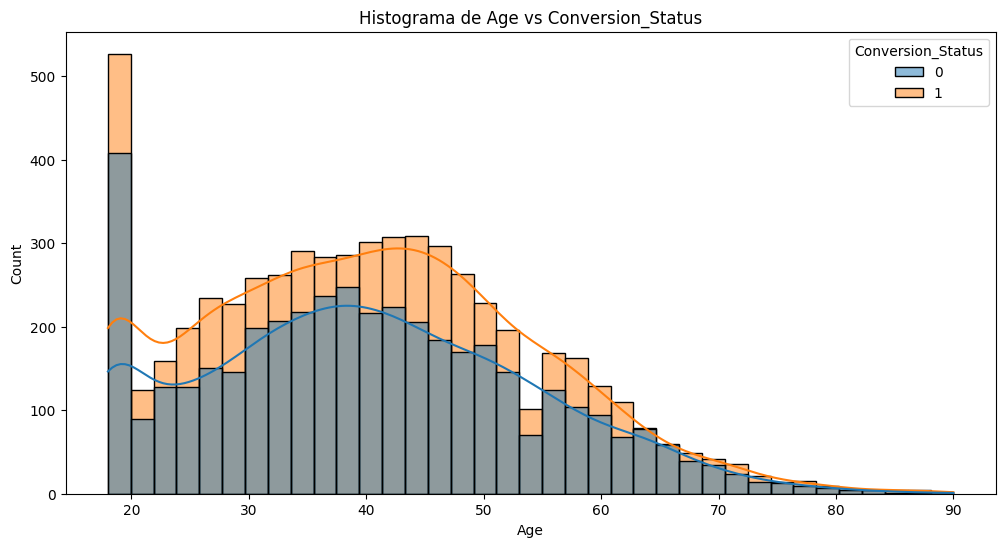

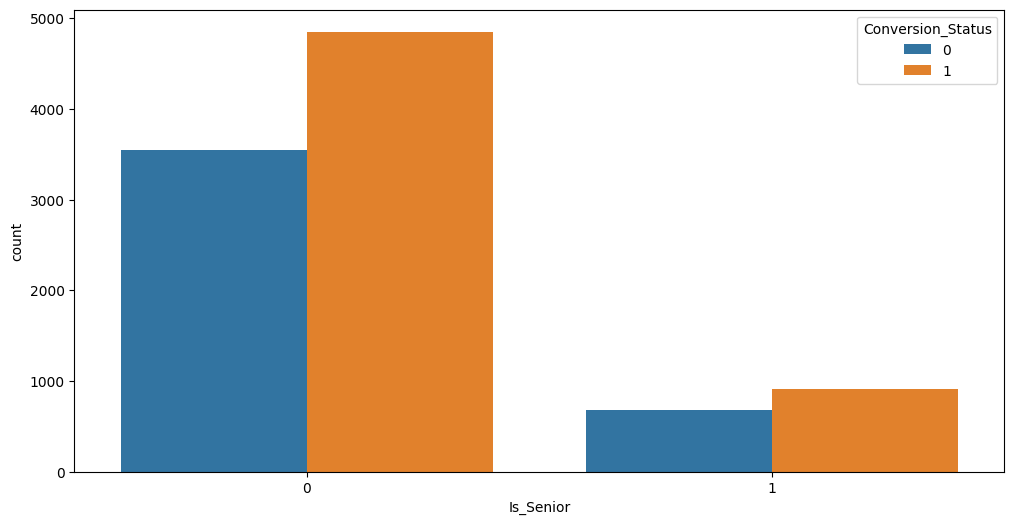

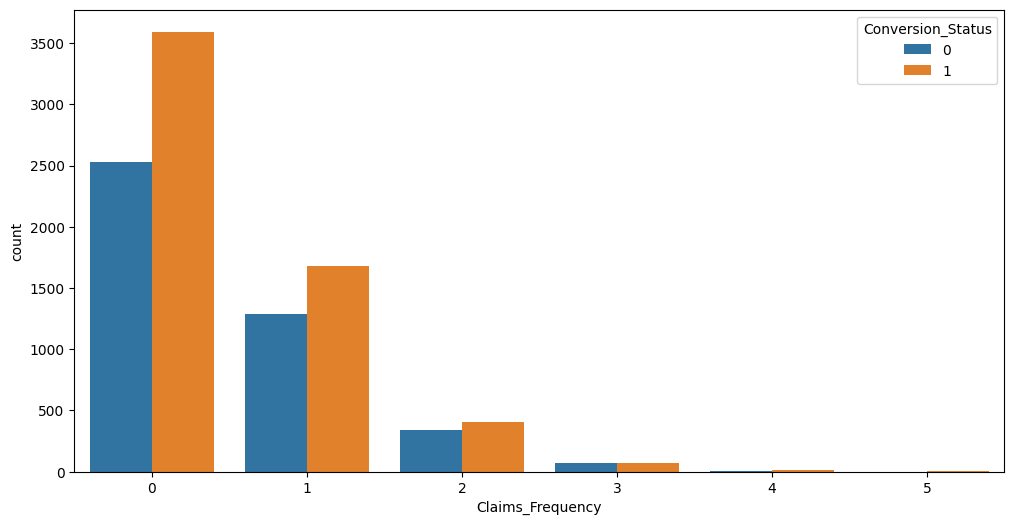

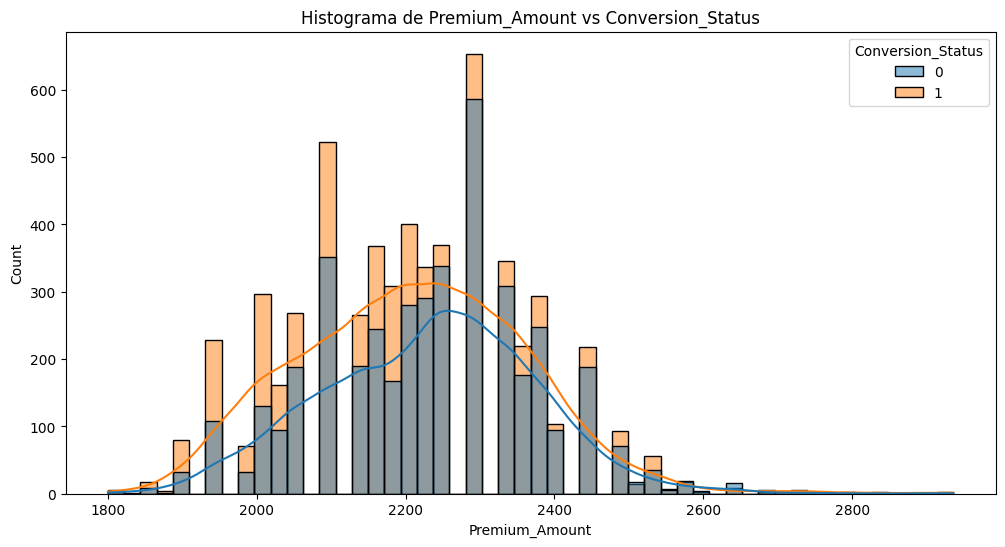

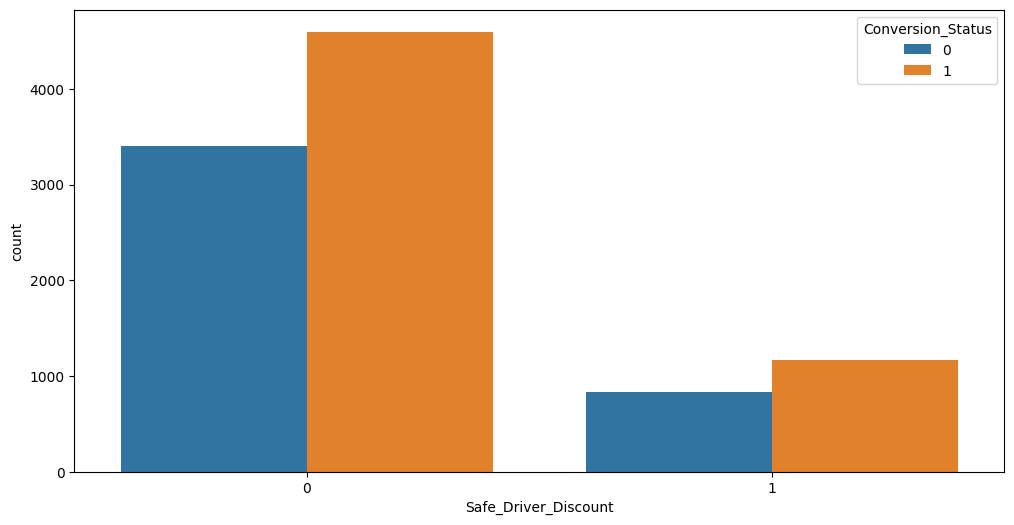

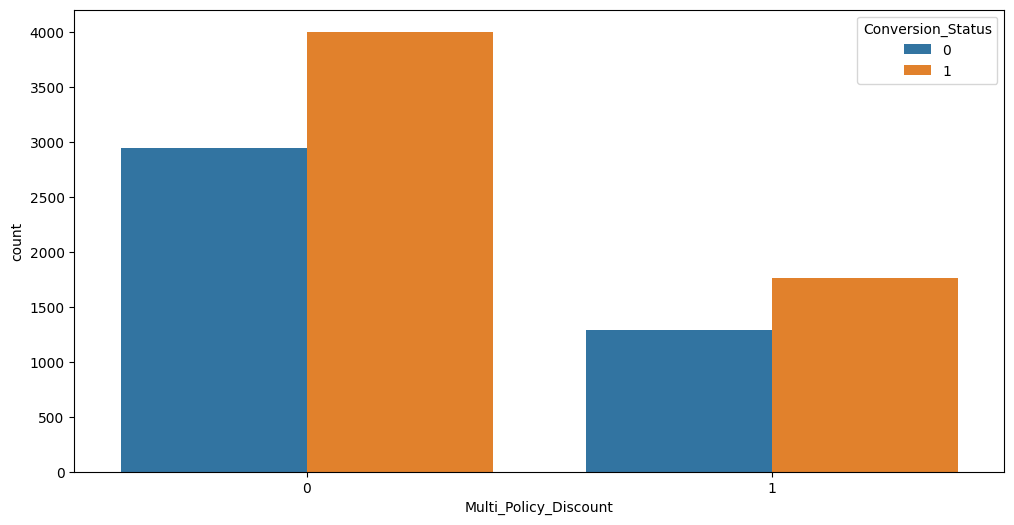

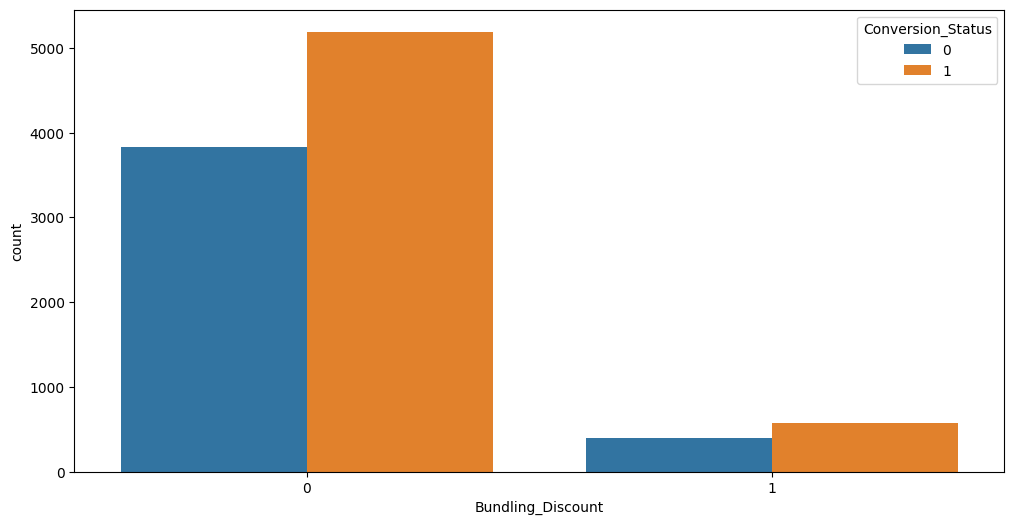

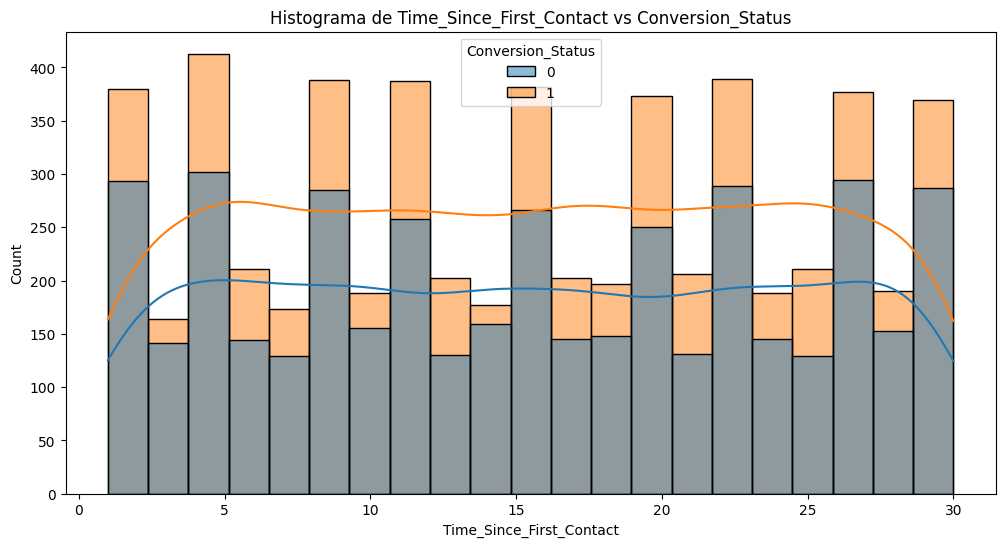

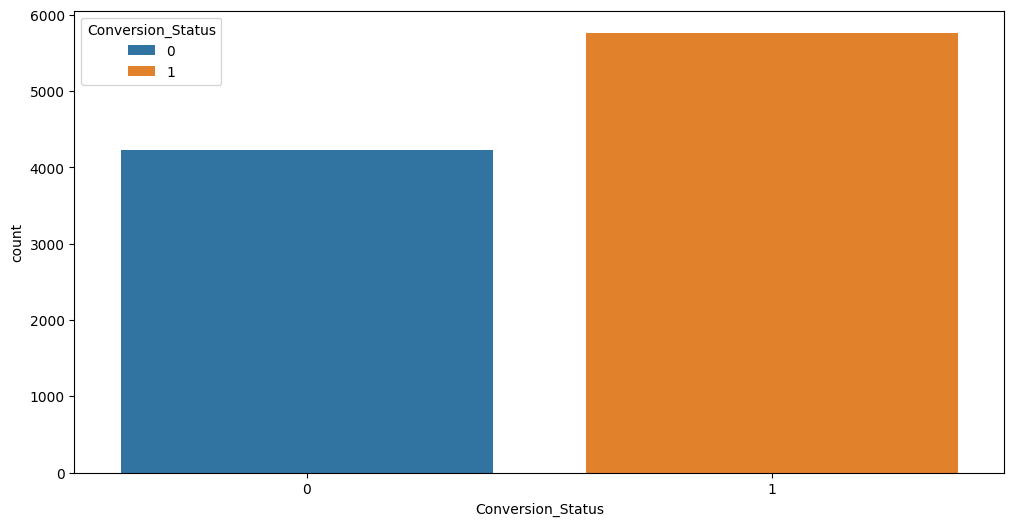

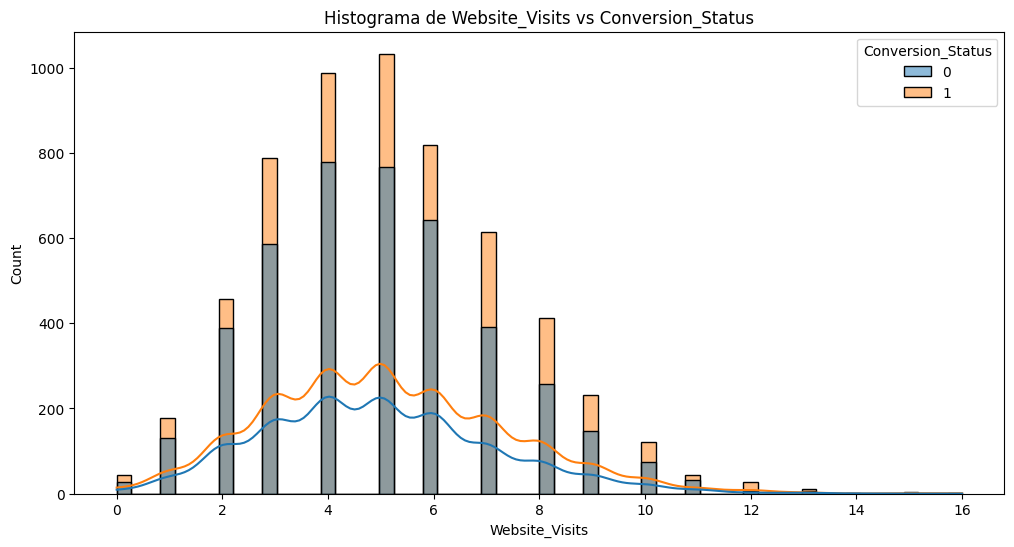

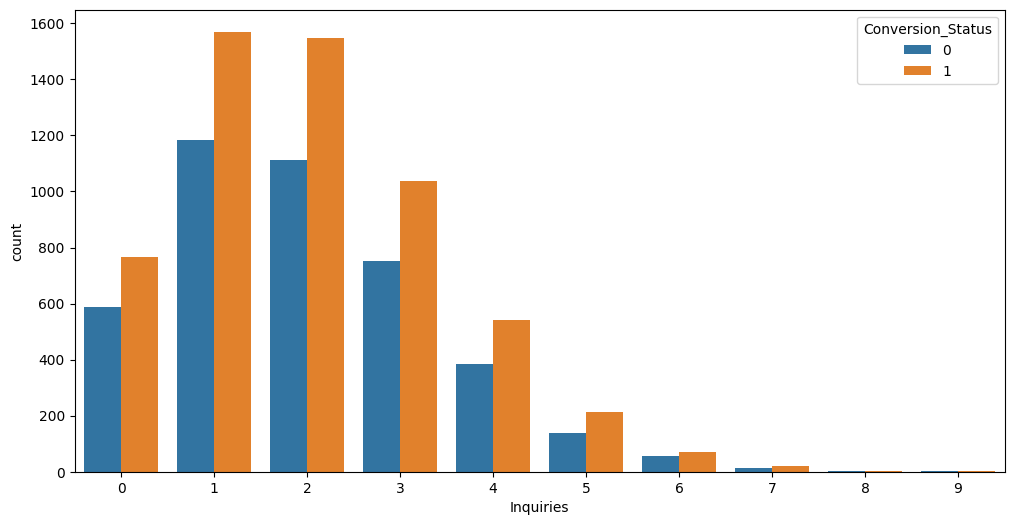

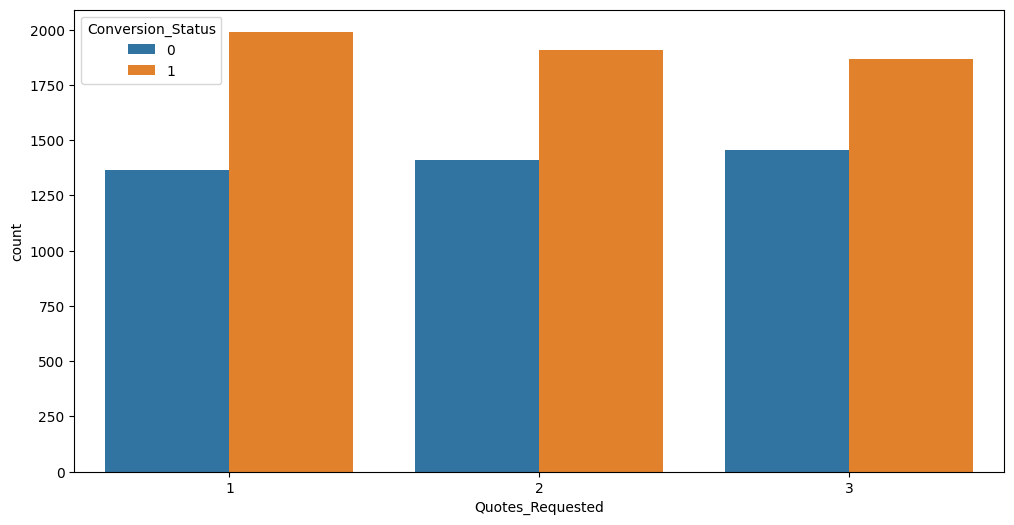

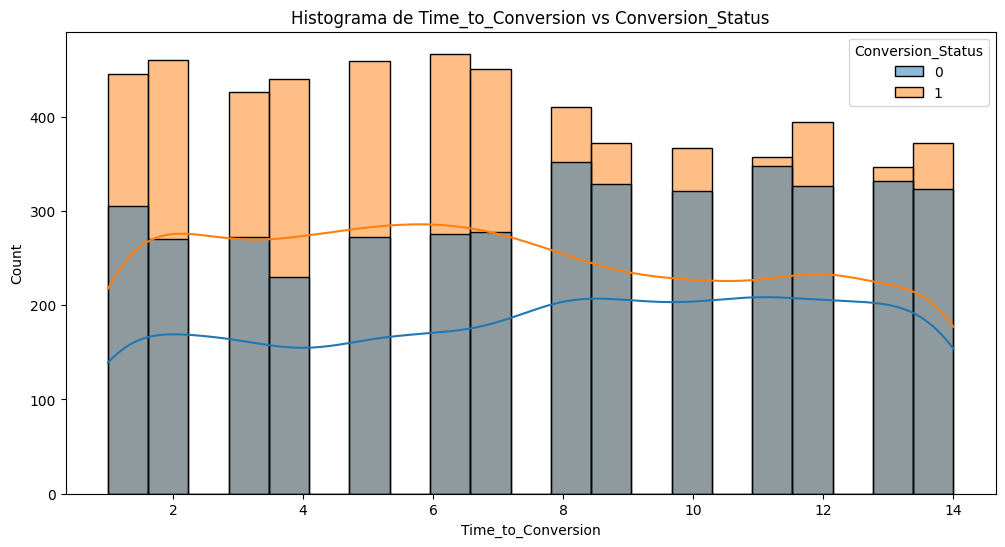

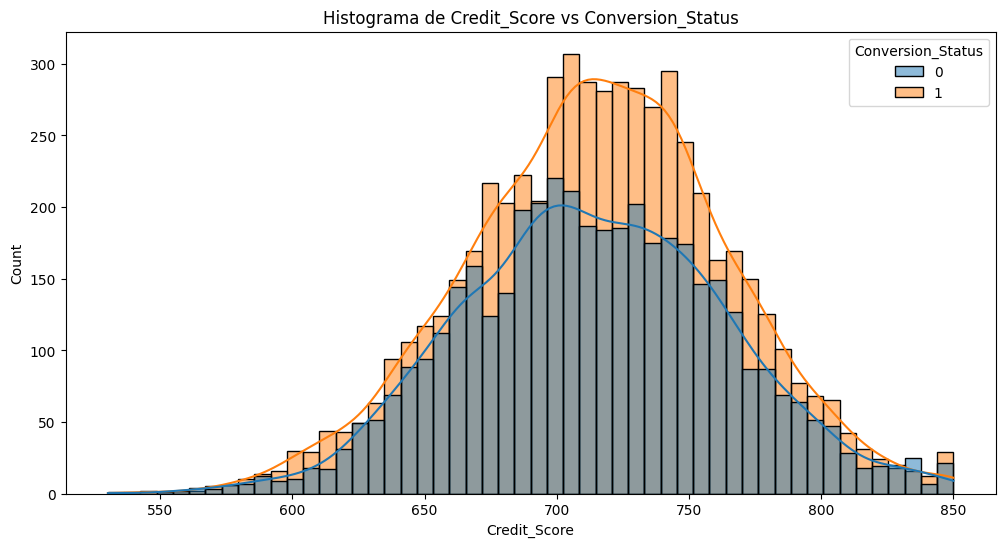

In [11]:
# Para cada variable numérico con más de 10 valores únicos, realizo un histograma y un scatterplot, sino barplot. Ambos casos diferenciados por series de Conversion_Status

for col in df_num.columns:
    if df_num[col].nunique() > 10:
        plt.figure(figsize=(12, 6))
        sns.histplot(df, x=col, hue='Conversion_Status', kde=True)
        plt.title(f'Histograma de {col} vs Conversion_Status')

    else:
        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, x=col, hue='Conversion_Status')

# Análisis adicional con crosstab para ver proporciones en los casos numéricos con menos de 10 valores únicos

for col in df_num.columns:
    if col != 'Conversion_Status' and df_num[col].nunique() < 11:
        print(pd.crosstab(df[col], df['Conversion_Status'], normalize='index') * 100)


Se destaca que hay variables que no son iguales al balanceo de la variable. Se destaca:
* Claims_Frequency: a valores altos hay muy alta relación al Conversion_Status
* Total_Discounts: ni bien los descuentos por separado no hay tenido muy buenos valores, cuando están los 3 descuentos llevando a 150 USD se eleva relevantemente.
* Inquiries: hay casos de valores con mucha inclinación hacia alguna opción de Conversion_Status, superando el balanceo.
* Time_to_Conversion: se puede analizar que los valores bajos son propensos a tener Conversion_Status positivo mientras que los altos tienden al caso negativo.
* Credit_Score: en sus valores extremos tiende a no convertir, mientras que en el centro de la normal tiende a concentrar ventas.

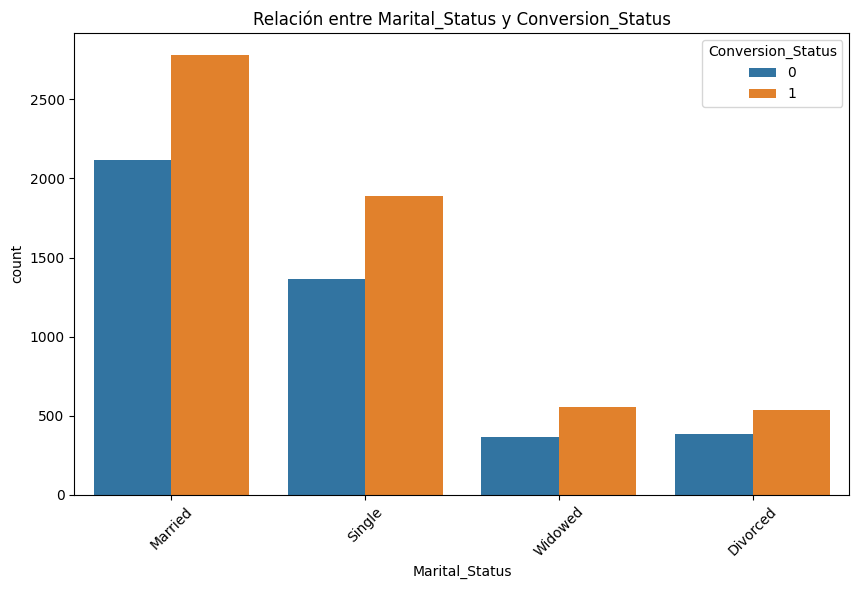

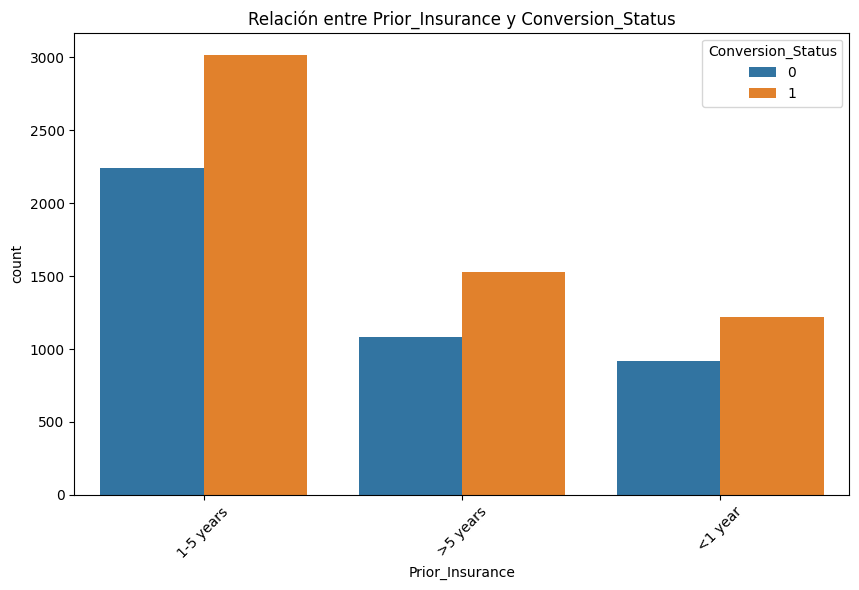

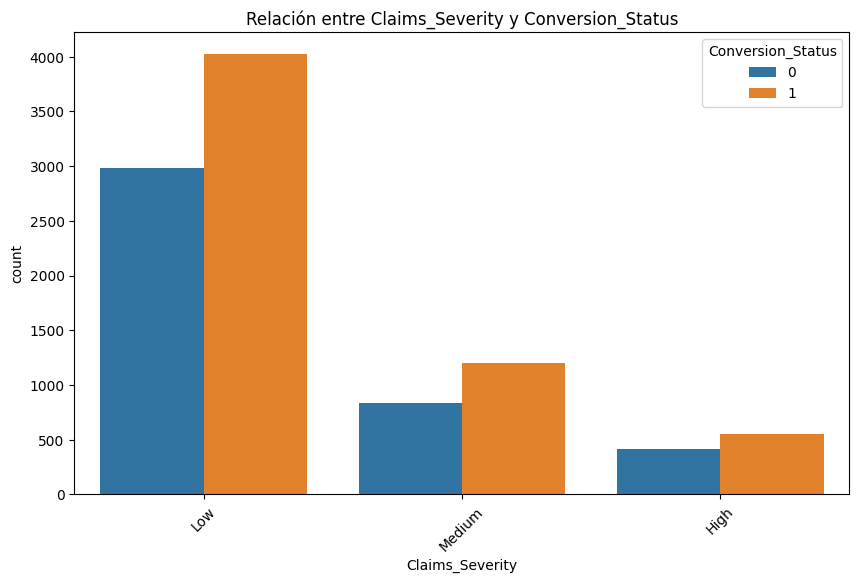

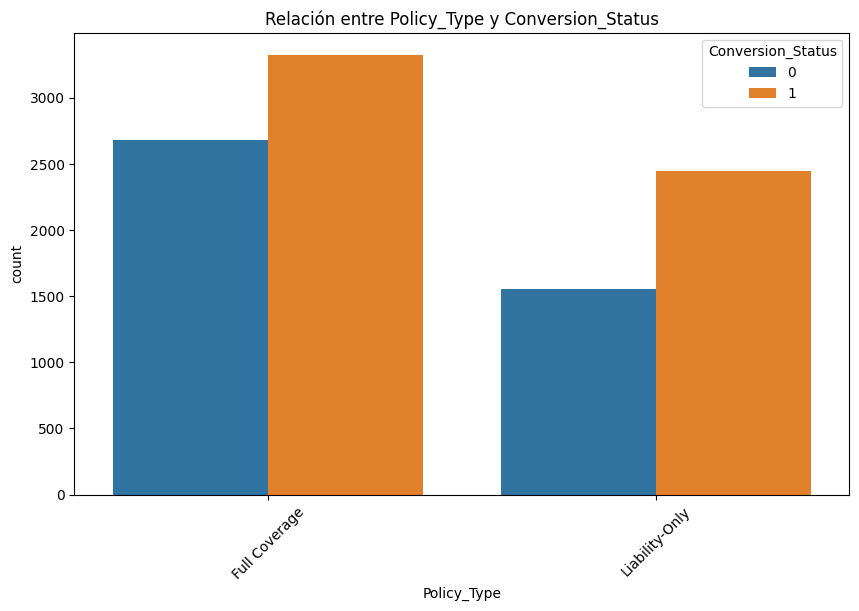

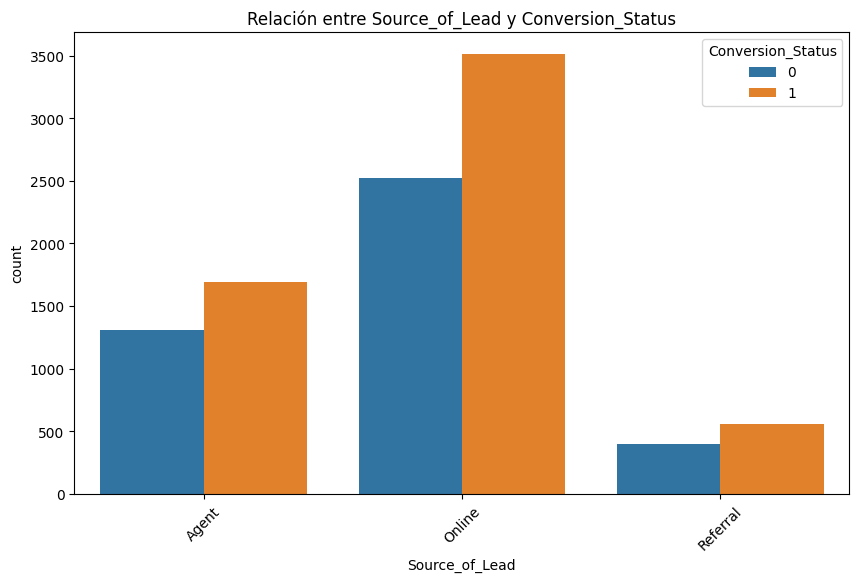

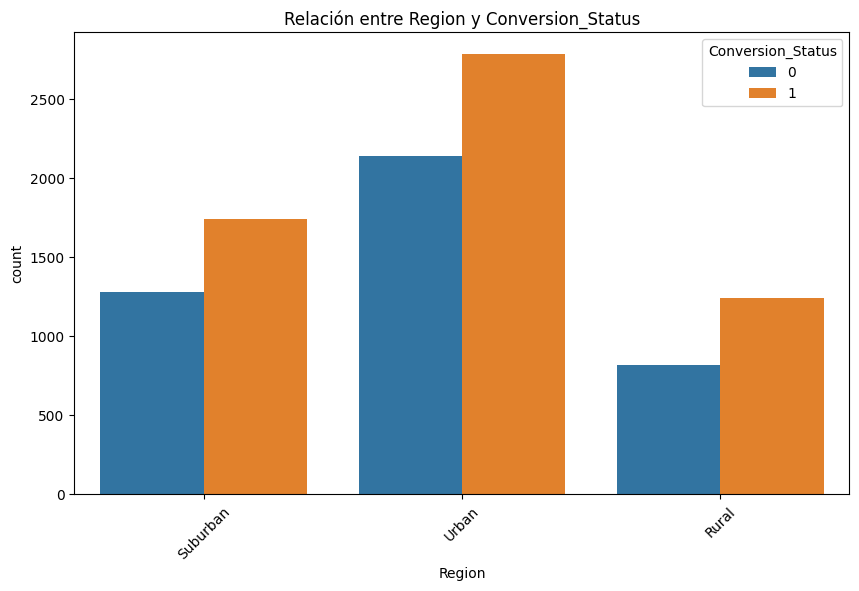

Conversion_Status          0          1
Marital_Status                         
Divorced           41.521739  58.478261
Married            43.212901  56.787099
Single             41.945382  58.054618
Widowed            39.804772  60.195228
Conversion_Status          0          1
Prior_Insurance                        
1-5 years          42.590831  57.409169
<1 year            42.830366  57.169634
>5 years           41.395171  58.604829
Conversion_Status          0          1
Claims_Severity                        
High               42.857143  57.142857
Low                42.581751  57.418249
Medium             41.216879  58.783121
Conversion_Status          0          1
Policy_Type                            
Full Coverage      44.647911  55.352089
Liability-Only     38.842975  61.157025
Conversion_Status          0          1
Source_of_Lead                         
Agent              43.675100  56.324900
Online             41.789561  58.210439
Referral           41.519251  58.480749


In [12]:
# Para cada variable categórica, realizo un barplot

for col in df_cat.columns:
    if col != 'Conversion_Status':
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='Conversion_Status', data=df)
        plt.title(f'Relación entre {col} y Conversion_Status')
        plt.xticks(rotation=45)
        plt.show()

# Análisis adicional con crosstab para ver proporciones

for col in df_cat.columns:
    if col != 'Conversion_Status':
        print(pd.crosstab(df[col], df['Conversion_Status'], normalize='index') * 100)


Conociendo que el valor de la variable objetivo es 57,7% de casos positivos, se pueden distinguir algunas variable que tienen cierta mayor tendencia:
* Policy_Type: tiene mejor relación cuando es Liability-Only
* Region: cuando es Rural
* Marital_Status: cuando es Widowed

##Análisis Multivariado

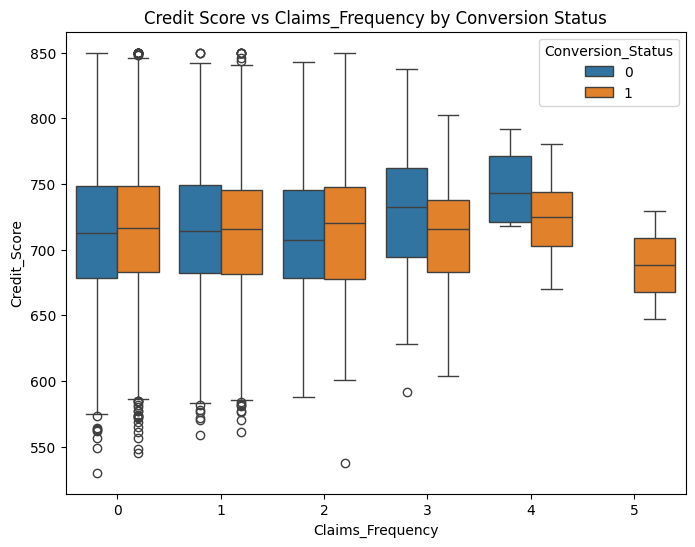

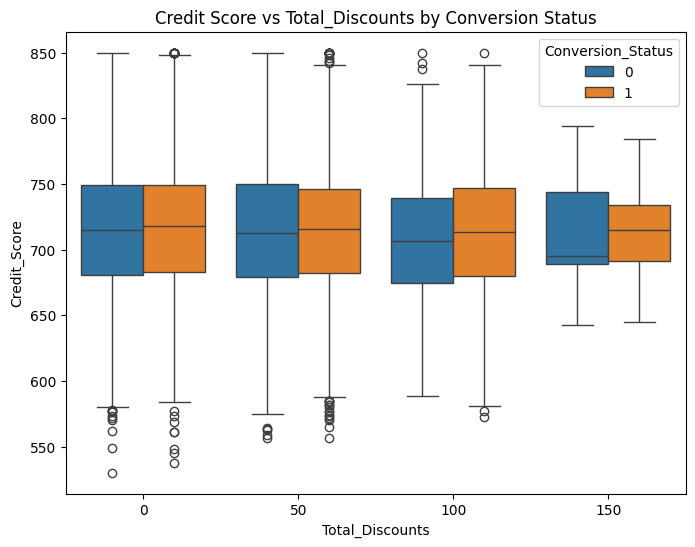

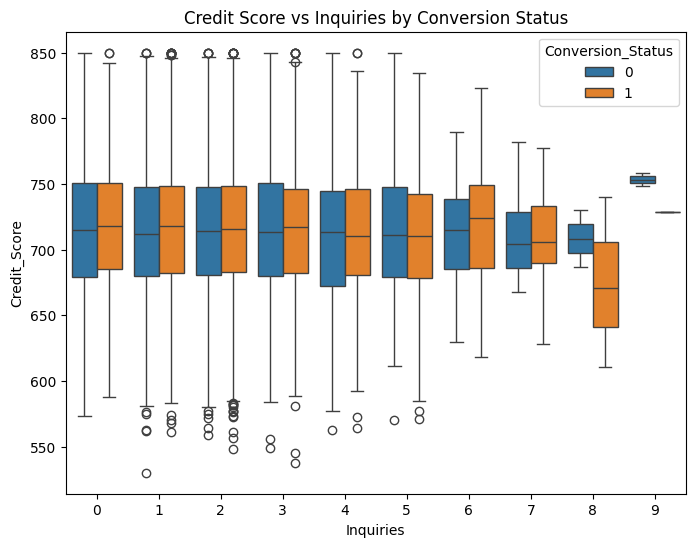

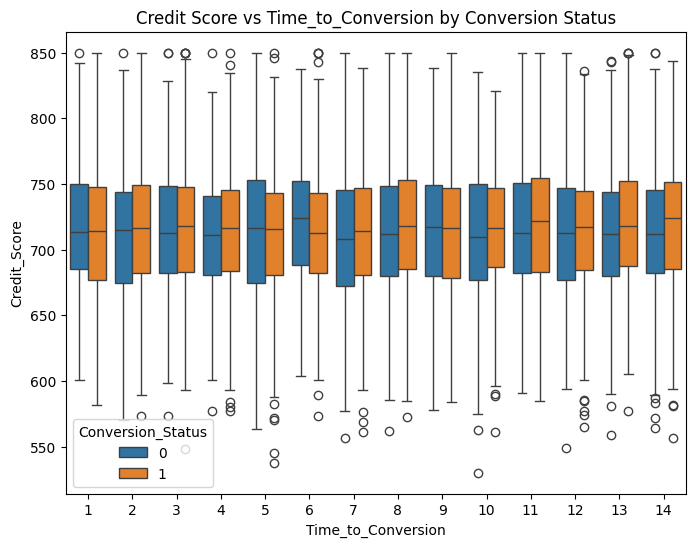

In [33]:
# Realizo múltiples Boxplots para analizar si el Credit_Score infiere sobre el comportamiento del cliente.
for col in ['Claims_Frequency', 'Total_Discounts', 'Inquiries', 'Time_to_Conversion']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=col, y='Credit_Score', hue='Conversion_Status', data=df)
    plt.title(f'Credit Score vs {col} by Conversion Status')
    plt.show()


Se puede analizar que a niveles altos de Inquiries y Claim_Frequency, a más bayor Credit_Score, más propenso a comprar. Por otro lado, a mayor Total_Discounts, los Credit_Score mayores a 700 tienden a comprar.

##Conclusiones del EDA

Se destaca la posibilidad de uso de las variables para el análisis:


1.   Claims_Frequency
2.   Total_Discounts
3.   Inquiries
4.   Time_to_Conversion
5.   Credit_Score
6.   Policy_Type
7.   Libaility-Only
8.   Region
9.   Marital_Status


#Modelo de predicción

Para comenzar, se definirá un nuevo df que solo contenga las variables que se han destacado previamente.

In [31]:
df_2 = df[['Claims_Frequency','Total_Discounts','Inquiries','Time_to_Conversion','Credit_Score','Policy_Type','Region','Marital_Status','Conversion_Status']]

In [39]:
X=df_2.drop("Conversion_Status", axis=1)
Y=df_2["Conversion_Status"]

En consecuencia a que las variables son categóricas o numéricas con pocos valores únicos, se procede a utilizar OneHotEncoder en todas.

In [42]:
# Convierto neighbourhood de los datos de entrenamiento en columnas de 0 y 1. Lo realizo previo a la subdivisión de datos de entrenamiento y testeo para asegurar la presencia de las mismas columnas en ambos segmentos.

ohe = OneHotEncoder(sparse_output=False).fit(X)
encoded = ohe.transform(X)
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(), index=X.index)
X = pd.concat([X, encoded_df], axis=1)

In [43]:
# Elimino las columnas originales

X = X.drop(['Claims_Frequency','Total_Discounts','Inquiries','Time_to_Conversion','Policy_Type','Region','Marital_Status'], axis=1)

##Datos de test y training

Procedo a separar datos de test y training

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

##Modelo de predicción

Se utilizará un árbol de decisión debido a que los valores tienen pocos valores únicos. Es por este motivo también que previamente se procedió con el OneHotEncoder.

In [56]:
# Ejecuto el armado del árbol con datos de entrenamiento

clf = DecisionTreeClassifier(random_state=42).fit(X_train, Y_train)

In [57]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

##Indicadores del modelo

In [58]:
print(classification_report(Y_train, train_pred))
print("------------------------------------------------------")
print(classification_report(Y_test, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2932
           1       1.00      1.00      1.00      4068

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000

------------------------------------------------------
              precision    recall  f1-score   support

           0       0.45      0.39      0.42      1301
           1       0.58      0.63      0.60      1699

    accuracy                           0.53      3000
   macro avg       0.51      0.51      0.51      3000
weighted avg       0.52      0.53      0.52      3000



#Conclusiones Finales

Actualmente, el modelo cuenta con Overfitting. Queda pendiente mejorar los resultados del modelo.